## Logistical regression on Titanic survival

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingRegressor
sns.set_theme()

In [160]:
data_train=pd.read_csv("/content/train.csv")
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [161]:
# Information about the dataframe
def info_of_data(Data):
    Output=pd.DataFrame(
        {
                    "Tpye" : Data.dtypes,
                    "No_of_elements" : Data.count(),
                    "No_Invalid_Elements" : Data.isnull().sum(),
                    "Unique_Elements" : Data.nunique()
        }
    )
    return Output

In [162]:
info_of_data(data_train)

,Tpye,No_of_elements,No_Invalid_Elements,Unique_Elements
PassengerId,int64,891,0,891
Survived,int64,891,0,2
Pclass,int64,891,0,3
Name,object,891,0,891
Sex,object,891,0,2
Age,float64,714,177,88
SibSp,int64,891,0,7
Parch,int64,891,0,7
Ticket,object,891,0,681
Fare,float64,891,0,248


Converting Data to train model

In [163]:
# processing data filling emplty spaces in cabin column with ukn
data_train["Cabin"]=data_train["Cabin"].fillna("UNK")
# counting total no of family members
data_train["familymembers"]=(data_train["SibSp"] + data_train["Parch"]).astype("int")
# from the cabin details we can extract deck details
data_train["Deck"]=data_train["Cabin"].apply(lambda x: "UNK" if x=="UNK" else x[0])
# filling empty age entities with mean
data_train["Age"]=data_train["Age"].fillna((data_train["Age"].mean()))
# finding fare per person
data_train["fare_per_person"]=(data_train['Fare']/(data_train['familymembers']+1)).astype("float")
# filling empty Enbarked entities with most occuring entity i.e., mode
data_train["Embarked"]=data_train["Embarked"].fillna((data_train["Embarked"].mode()[0][0]))
# dropping unwanted columns
data_train=data_train.drop(['Cabin','PassengerId','Name',"SibSp","Parch","Ticket"], axis=1)
# converting categorical column to binary
data_train["Sex"]=data_train["Sex"].apply(lambda x: 1 if x=="male" else 0)
data_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,familymembers,Deck,fare_per_person
0,0,3,1,22.0,7.2500,S,1,UNK,3.62500
1,1,1,0,38.0,71.2833,C,1,C,35.64165
2,1,3,0,26.0,7.9250,S,0,UNK,7.92500
3,1,1,0,35.0,53.1000,S,1,C,26.55000
4,0,3,1,35.0,8.0500,S,0,UNK,8.05000


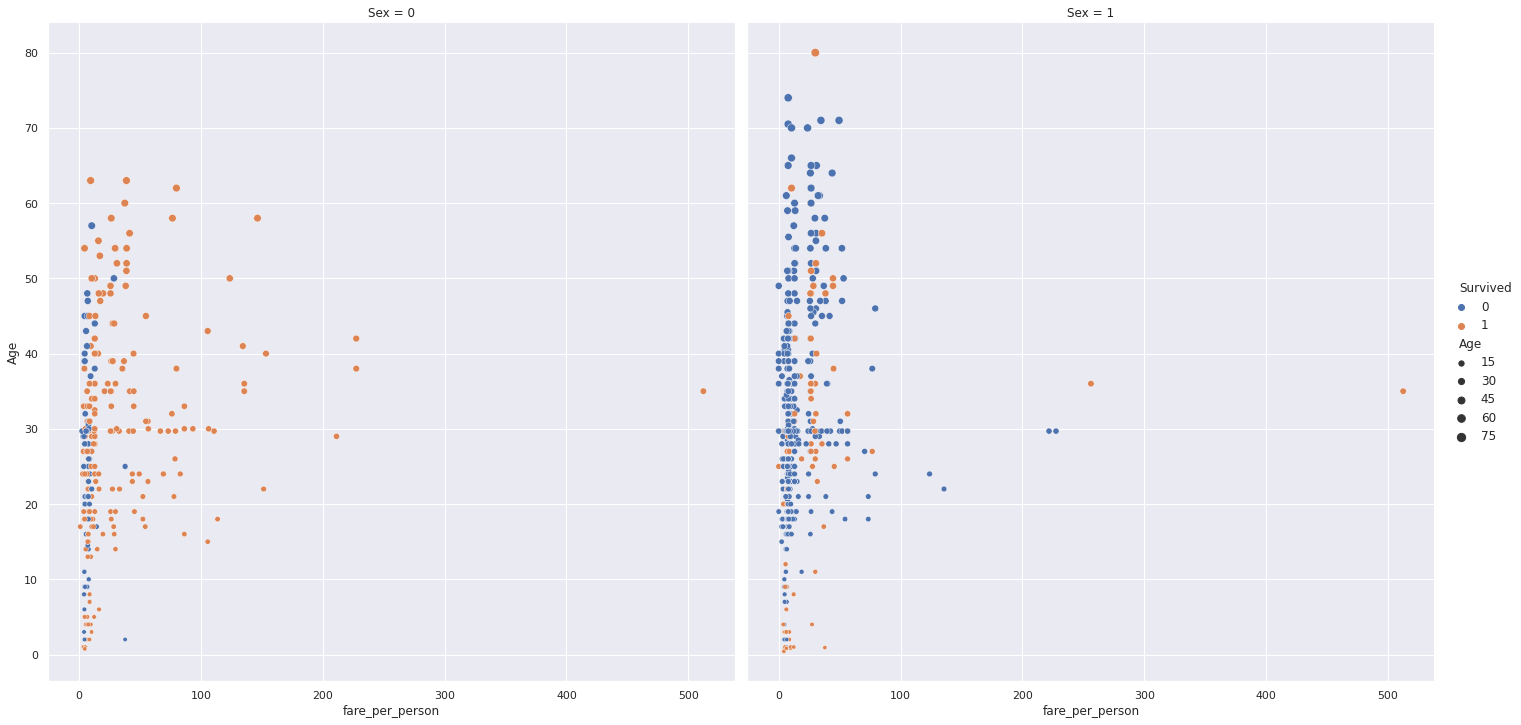

In [164]:
sns.relplot(
    data=data_train,
    x="fare_per_person", y="Age",col="Sex",
    hue="Survived", size="Age", height = 10,
)

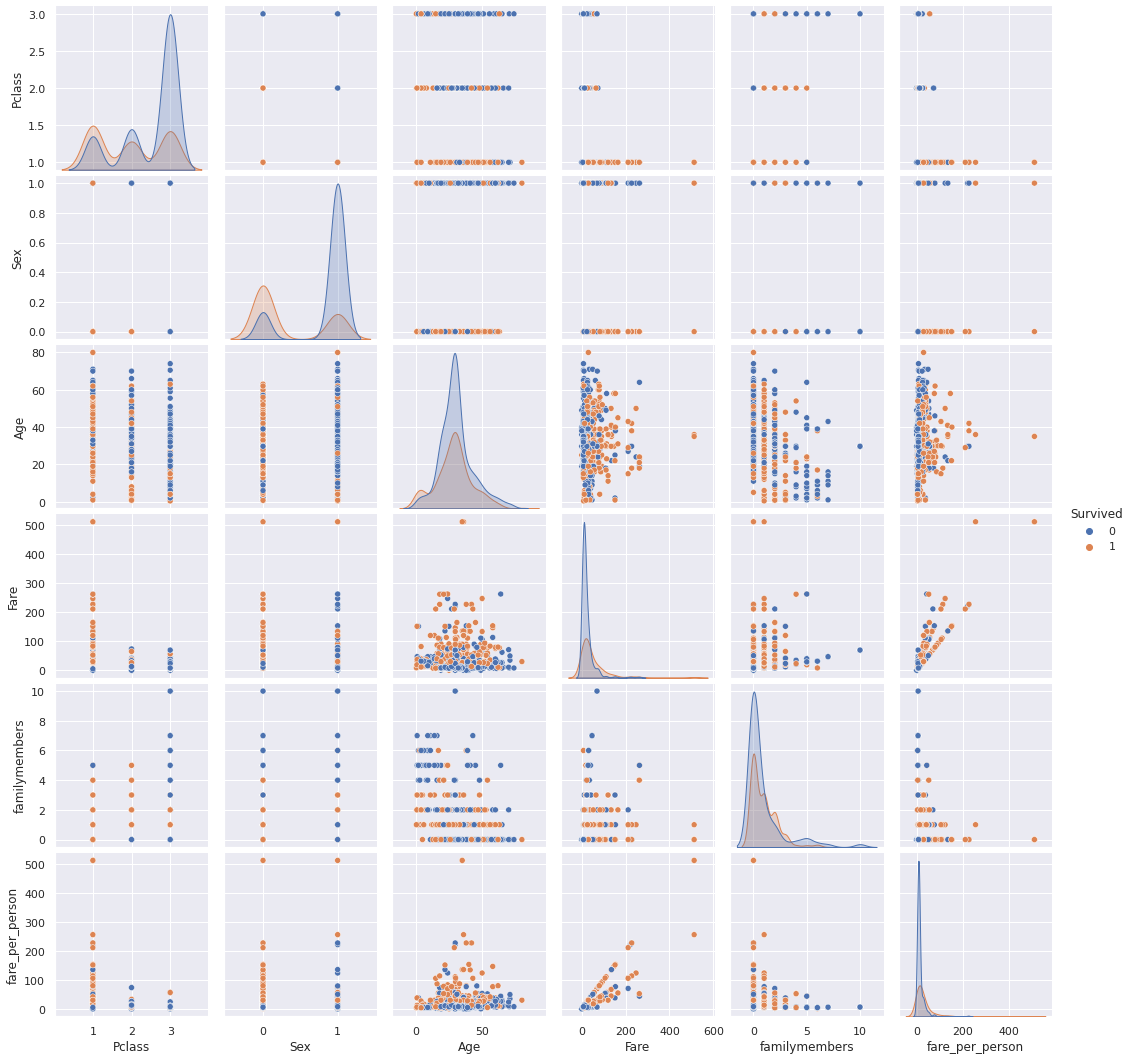

In [133]:
sns.pairplot(data=data_train, hue="Survived")

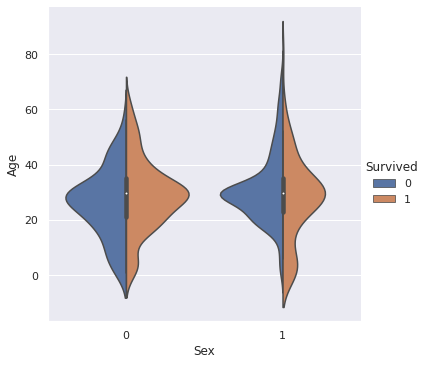

In [134]:
sns.catplot(data=data_train, kind="violin", x="Sex", y="Age", hue="Survived", split=True)

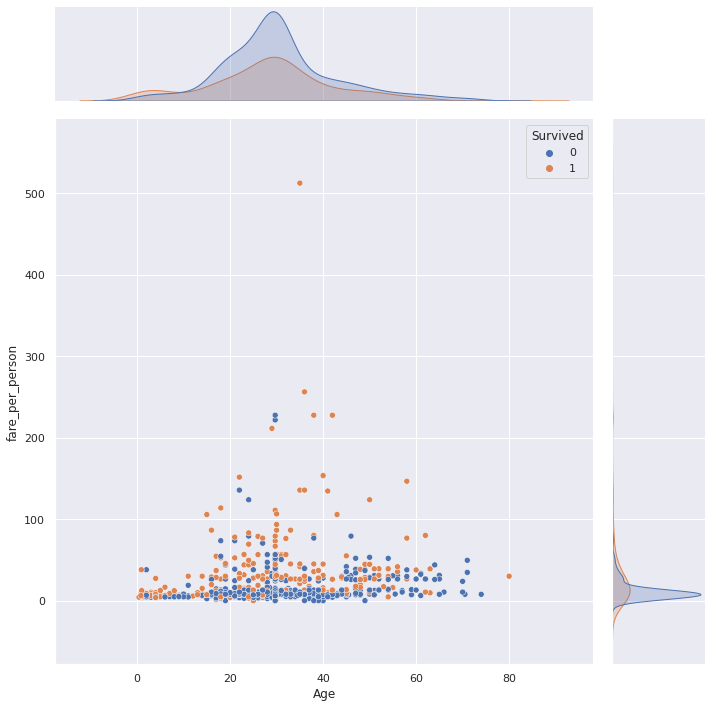

In [135]:
sns.jointplot(data=data_train, x="Age", y="fare_per_person", hue="Survived",height=10)

In [165]:
dummy = data_train[['Pclass','Embarked','Deck']]
dummy = pd.get_dummies(dummy,drop_first=True)
data_train = pd.concat([dummy,data_train],axis = 1)
data_train.drop(['Pclass','Embarked','Deck','Fare','Deck_T'], axis = 1, inplace = True)
# introducing dummies to remove string data of catagories
data_train.head()

,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_UNK,Survived,Sex,Age,familymembers,fare_per_person
0,0,1,0,0,0,0,0,0,1,0,1,22.0,1,3.62500
1,0,0,0,1,0,0,0,0,0,1,0,38.0,1,35.64165
2,0,1,0,0,0,0,0,0,1,1,0,26.0,0,7.92500
3,0,1,0,1,0,0,0,0,0,1,0,35.0,1,26.55000
4,0,1,0,0,0,0,0,0,1,0,1,35.0,0,8.05000


Lets split data for the sake of training and validation

In [166]:
X=data_train.drop(["Survived"], axis=1)
y=data_train["Survived"]
X_train, X_val, y_train, y_val= train_test_split(X, y,test_size=0.2, stratify=y, random_state=1)

Lets try Descision trees for classification

In [188]:
dt = DecisionTreeClassifier(criterion='gini', random_state=1)

dt.fit(X_train,y_train)
# Predict test-set labels
y_pred= dt.predict(X_val)
# Evaluate test-set accuracy
accuracy_decision_Tree=accuracy_score(y_val, y_pred)
accuracy_decision_Tree

0.7821229050279329

Lets try XGboost now

In [168]:
import xgboost as xgb

In [189]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xg_cl.fit(X_train, y_train) 
preds = xg_cl.predict(X_val)
accuracy_xgboost = float(np.sum(preds==y_val))/y_val.shape[0] 
print("accuracy: %f" % (accuracy_xgboost))

accuracy: 0.821229


Logistical regression

In [170]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [190]:
y_pred=clf.predict(X_val)
accuracy_logistic = float(np.sum(y_pred==y_val))/y_val.shape[0] 
print("accuracy: %f" % (accuracy_logistic))

accuracy: 0.782123


Prediction on Test set

In [181]:
data_test=pd.read_csv("/content/test.csv")
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [182]:
data_test["Cabin"]=data_test["Cabin"].fillna("UNK")
data_test["familymembers"]=(data_test["SibSp"] + data_test["Parch"]).astype("int")
data_test["Deck"]=data_test["Cabin"].apply(lambda x: "UNK" if x=="UNK" else x[0])
data_test["Age"]=data_test["Age"].fillna((data_test["Age"].mean()))
data_test["fare_per_person"]=(data_test['Fare']/(data_test['familymembers']+1)).astype("float")
data_test["fare_per_person"]=data_test["fare_per_person"].fillna((data_test["fare_per_person"].mean()))
data_test["Embarked"]=data_test["Embarked"].fillna((data_test["Embarked"].mode()[0][0]))
data_test=data_test.drop(['Cabin','PassengerId','Name',"SibSp","Parch","Ticket"], axis=1)
data_test["Sex"]=data_test["Sex"].apply(lambda x: 1 if x=="male" else 0)
data_test.head()

,Pclass,Sex,Age,Fare,Embarked,familymembers,Deck,fare_per_person
0,3,1,34.5,7.8292,Q,0,UNK,7.829200
1,3,0,47.0,7.0000,S,1,UNK,3.500000
2,2,1,62.0,9.6875,Q,0,UNK,9.687500
3,3,1,27.0,8.6625,S,0,UNK,8.662500
4,3,0,22.0,12.2875,S,2,UNK,4.095833


In [183]:
dummy = data_test[['Pclass','Embarked','Deck']]
dummy = pd.get_dummies(dummy,drop_first=True)
data_test = pd.concat([dummy,data_test],axis = 1)
data_test.drop(['Pclass','Embarked','Deck','Fare'], axis = 1, inplace = True)
data_test.head()

,Embarked_Q,Embarked_S,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_UNK,Sex,Age,familymembers,fare_per_person
0,1,0,0,0,0,0,0,0,1,1,34.5,0,7.829200
1,0,1,0,0,0,0,0,0,1,0,47.0,1,3.500000
2,1,0,0,0,0,0,0,0,1,1,62.0,0,9.687500
3,0,1,0,0,0,0,0,0,1,1,27.0,0,8.662500
4,0,1,0,0,0,0,0,0,1,0,22.0,2,4.095833


In [184]:
# prediction by xgboost
y_pred_xg= xg_cl.predict(data_test)

In [185]:
# prediction by descision tree
y_pred_dt= dt.predict(data_test)

In [186]:
# prediction by logistical regression
y_pred_log=clf.predict(data_test)

In [191]:
accuracy_decision_Tree, accuracy_logistic, accuracy_xgboost

(0.7821229050279329, 0.7821229050279329, 0.8212290502793296)

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [197]:
# /content/drive/MyDrive/College

pd.DataFrame(y_pred_xg).to_csv("/content/drive/MyDrive/College/y_pred_xg.csv")

In [198]:
pd.DataFrame(y_pred_dt).to_csv("/content/drive/MyDrive/College/y_pred_dt.csv")
pd.DataFrame(y_pred_log).to_csv("/content/drive/MyDrive/College/y_pred_log.csv")